In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

!pip install anaconda bcolz
!pip install anaconda isoweek
!pip install anaconda pandas-summary

     |████████████████████████████████| 122kB 6.5MB/s 
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57
     |████████████████████████████████| 519.5MB 43kB/s 
     |████████████████████████████████| 61kB 17.9MB/s 
ERROR: fastai 0.7.0 requires bcolz, which is not installed.
ERROR: fastai 0.7.0 requires isoweek, which is not installed.
ERROR: fastai 0.7.0 requires pandas-summary, which is not installed.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0
     |████████████████████████████████| 1.5MB 6.5MB/s 
  Created wheel for anaconda: filename=anaconda-0.0.1.1-cp36-none-any.whl size=1124 sha256=275d25a51398aab7068ae7dd61d

In [2]:
#imports
import torch
from bokeh.plotting import figure, show, output_notebook, save, output_file

from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

#fastai related imports
import fastai
from fastai.learner import *
from fastai.column_data import *
import seaborn as sns
import sklearn.metrics as metrics

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

torch.cuda.is_available()

True

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [4]:
print(torch.__version__)

0.4.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [67]:
path='/content/drive/My Drive/Colab Notebooks/' #path to the dataset
data = pd.read_csv(f'{path}trainset.csv')
print(data.head())
test = pd.read_csv(f'{path}testset.csv')
print(test.head())

data = data[['cmpd_id', 'target_id', 'pKd']] #dropping cells .. not needed for this study
print(len(data))

test = test[['cmpd_id', 'target_id', 'pKd']] #dropping cells .. not needed for this study
print(len(test))

   Unnamed: 0        cmpd_id target_id  ...  P97612  P51141  P97266
0           1  CHEMBL1232461    P25440  ...   0.104   0.211   0.039
1           2  CHEMBL1232461    O60885  ...   0.044   0.146   0.022
2          10  CHEMBL3645119    P52333  ...   0.181   0.182   0.037
3          11  CHEMBL3645119    P43405  ...   0.239   0.145   0.053
4          13  CHEMBL3645119    P23458  ...   0.150   0.183   0.028

[5 rows x 804 columns]
   Unnamed: 0        cmpd_id target_id  ...  P97612  P51141  P97266
0           4  CHEMBL3669127    P63085  ...   0.041   0.026   0.084
1           5  CHEMBL3669127    P47811  ...   0.208   0.030   0.113
2           6  CHEMBL2386796    Q9UM73  ...   0.107   0.090   0.023
3           7  CHEMBL3605998    P11103  ...   0.140   0.218   0.045
4           8  CHEMBL3669571    O43614  ...   0.013   0.018   0.128

[5 rows x 804 columns]
13786
40218


In [68]:
data.shape, test.shape 


((13786, 3), (40218, 3))

In [69]:
combined = pd.concat([data, test])
combined.head()

,cmpd_id,target_id,pKd
0,CHEMBL1232461,P25440,7.000000
1,CHEMBL1232461,O60885,7.187087
2,CHEMBL3645119,P52333,8.537602
3,CHEMBL3645119,P43405,7.008774
4,CHEMBL3645119,P23458,8.173925


In [70]:
cats = ['cmpd_id', 'target_id']
for c in cats:
    combined[c] = combined[c].astype('category').cat.codes

combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54004 entries, 0 to 40217
Data columns (total 3 columns):
cmpd_id      54004 non-null int16
target_id    54004 non-null int16
pKd          54004 non-null float64
dtypes: float64(1), int16(2)
memory usage: 1.0 MB


In [71]:
cat_sz = [(c, len(combined[c].unique())) for c in cats]
cat_sz

[('cmpd_id', 13498), ('target_id', 1435)]

In [72]:
emb_szs = [(c, min(100, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(13498, 100), (1435, 100)]

In [73]:
data = combined[:len(data)]
test = combined[len(data):]

min_rating,max_rating = data.pKd.min(),data.pKd.max()
min_rating,max_rating

(1.80687540164554, 12.602059991328002)

# Collaborative filtering using pytorch and fastai

In [0]:
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)
      

class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

In [75]:
n_factors = emb_szs[0][1] #how big embedding matrix we want
n_users = int(cat_sz[0][1])
n_movies = int(cat_sz[1][1])
print(n_factors)
print(n_users)
print(n_movies)

#val_idxs = get_cv_idxs(len(data)) #20% validation 

100
13498
1435


In [0]:
from sklearn.model_selection import train_test_split

x = data.drop(['pKd'],axis=1)
y = data['pKd'].astype(np.float32) #pytorch requires every input to be of type float32

trn_df, val_df, trn_y, val_y = train_test_split(x, y, test_size=0.2, random_state=1)


In [77]:
#test_x = test_ratings.drop(['rating'],axis=1)
#test_y = test_ratings['rating'].astype(np.float32) #pytorch requires every input to be of type float32
test[cats]

,cmpd_id,target_id
0,9142,888
1,9142,766
2,4940,1397
3,8743,334
4,9199,74
5,9199,73
6,8915,1213
7,8915,136
8,8916,1213
9,8916,136


In [0]:
data = ColumnarModelData.from_data_frames(path, trn_df, val_df, trn_y.astype('float'), val_y.astype('float'), cats, 64, test_df = test[cats])

#md = ColumnarModelData.from_data_frames('/tmp', trn_df, val_df, trn_y.astype('int'), val_y.astype('int'), cats, 128, test_df=test[cats])

In [0]:
xmb,ymb,zmb = next(iter(data.trn_dl)) #storing a mini-batch


In [80]:
data.test_dl


### Defining the model class

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf) #creating embedding matrix of a given size
    e.weight.data.uniform_(-0.01,0.01) #initializing values within embedding matrix.Kaiming He initialization 
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            emb_szs[0], emb_szs[1], (cat_sz[0][1],1), (cat_sz[1][1],1)
        ]] #defining embedding matrix and bias matrix
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies))#.sum(1)  #dot product of embedding vectors
        print(um.size())
        res = um.sum(1) + self.ub(users).squeeze() + self.mb(movies).squeeze() #addition of bias
        #res = torch.unsqueeze(res,1)
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        #torch.unsqueeze(res, 1)
        #res.view(-1,-1)
        return res

In [84]:
model = EmbeddingDotBias(n_users, n_movies).cuda()
wd=2e-4 #weight decay

opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

fit(model, data, 10, opt, F.mse_loss)

 93%|█████████▎| 161/173 [00:01<00:00, 118.00it/s, loss=0.661]torch.Size([20, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([70, 100])
epoch      trn_loss   val_loss   
    0      0.680287   0.696578  
 93%|█████████▎| 161/173 [00:01<00:00, 120.58it/s, loss=0.591]torch.Size([20, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.S

[0.44191170413049774]

In [85]:
preds_trn = predict(model,data.trn_dl)
preds_val = predict(model,data.val_dl)
preds_test = predict(model,data.test_dl)


torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size

In [87]:
set_lrs(opt, 1e-3)
fit(model, data, 50, opt, F.mse_loss)

 98%|█████████▊| 170/173 [00:01<00:00, 107.00it/s, loss=0.0253]torch.Size([20, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([70, 100])
epoch      trn_loss   val_loss   
    0      0.025907   0.439339  
 97%|█████████▋| 168/173 [00:01<00:00, 120.02it/s, loss=0.0223]torch.Size([20, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch.Size([128, 100])
torch

[0.438567021344346]

In [88]:
preds_trn = predict(model,data.trn_dl)
preds_val = predict(model,data.val_dl)
preds_test = predict(model,data.test_dl)


torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size

1.368613811326387
0.662243925083578
1.8132418187608823


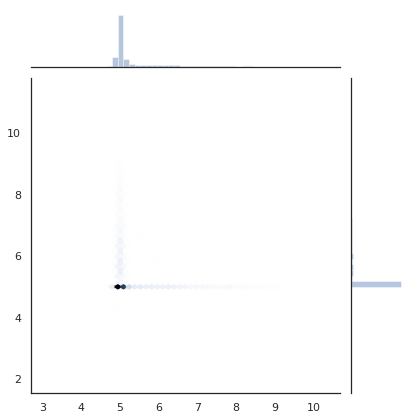

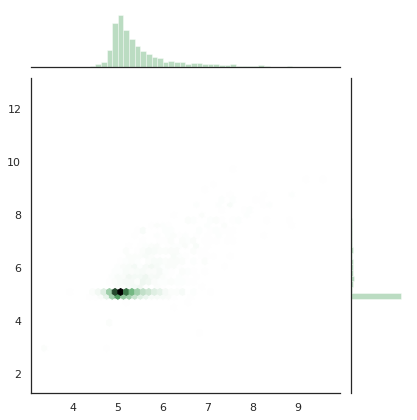

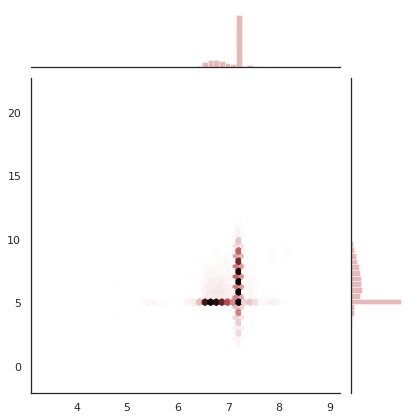

In [89]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
sns.set(style="white", color_codes=True)


preds = [preds_trn, preds_val, preds_test]

data_y = [data.trn_y, data.val_y, test.pKd.values]

sns.jointplot(preds[0], data_y[0], kind='hex', color="b", stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[0], data_y[0])))
#df_trn = pd.DataFrame({'predicted':preds_trn, 'actual':data.trn_y})
#print(df_trn)

sns.jointplot(preds[1], data_y[1], kind='hex', color="g",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[1], data_y[1])))

sns.jointplot(preds[2], data_y[2], kind='hex', color="r",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[2], data_y[2])))




In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh) 
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        res = F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5
        res = torch.squeeze(res,1)
        return res

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-4, weight_decay=wd)

In [58]:
fit(model, data, 50, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      1.843988   1.849628  
    1      1.698506   1.645617  
    2      1.408832   1.337178  
    3      1.073484   0.980567  
    4      0.930304   0.822703  
    5      0.797358   0.774572  
    6      0.834533   0.754605  
    7      0.809766   0.742787  
    8      0.790235   0.728716  
    9      0.76441    0.712976  
    10     0.743791   0.698454  
    11     0.724018   0.688124  
    12     0.745541   0.67543   
    13     0.69266    0.665029  
    14     0.721041   0.656803  
    15     0.725963   0.646776  
    16     0.665478   0.639816  
    17     0.649188   0.631978  
    18     0.644582   0.625166  
    19     0.654417   0.623109  
    20     0.646305   0.619299  
    21     0.616652   0.617238  
    22     0.635551   0.615233  
    23     0.624604   0.610085  
    24     0.612505   0.607309  
    25     0.613381   0.604863  
    26     0.602207   0.600303  
    27     0.608315   0.595841  
    28     0.581649   0.592651  
    29   

[0.5663343126398658]

In [0]:
preds_trn = predict(model,data.trn_dl)
preds_val = predict(model,data.val_dl)
preds_test = predict(model,data.test_dl)


1.368613811326387
0.662243925083578
1.8132418187608823


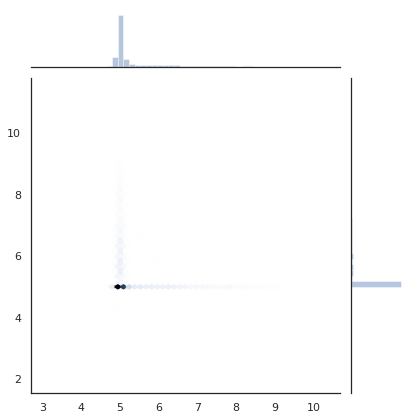

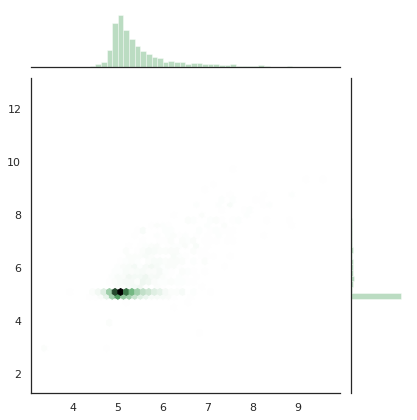

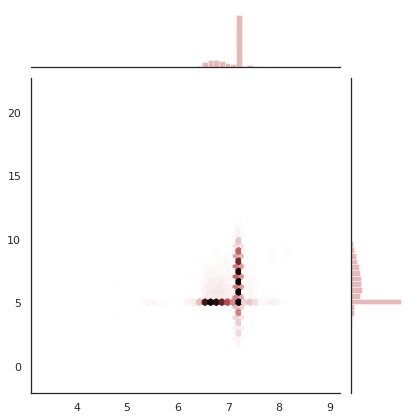

In [92]:
preds = [preds_trn, preds_val, preds_test]

data_y = [data.trn_y, data.val_y, test.pKd.values]

sns.jointplot(preds[0], data_y[0], kind='hex', color="b", stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[0], data_y[0])))
#df_trn = pd.DataFrame({'predicted':preds_trn, 'actual':data.trn_y})
#print(df_trn)

sns.jointplot(preds[1], data_y[1], kind='hex', color="g",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[1], data_y[1])))

sns.jointplot(preds[2], data_y[2], kind='hex', color="r",stat_func=None);
print(math.sqrt(metrics.mean_squared_error(preds[2], data_y[2])))


